# Transformer pipeline for music lyrics emotion classification

This notebook implements a complete workflow for **multi-class text classification** of **song lyrics into emotions** 
using a **custom Transformer architecture**.

The pipeline includes: tokenization, custom transformer layers with self-attention,
model building with proper Keras serialization, training with callbacks, comprehensive evaluation 
(accuracy, classification report, confusion matrix, ROC curves), saving model artifacts, 
and demonstration of single-sample predictions.

**Workflow:**
1. **Imports & Configuration** — set random seeds, define constants, configure paths, and setup mixed precision.
2. **Dataset Loading** — read preprocessed lyrics splits and inspect class distribution.
3. **Text Preprocessing** — custom tokenization with TensorFlow TextVectorization.
4. **Custom Transformer Architecture** — Multi-head self-attention, feed-forward networks, positional embeddings.
5. **Model Building** — Modular transformer blocks with proper layer serialization.
6. **Training** — fit model with callbacks (early stopping, learning rate scheduling).
7. **Comprehensive Evaluation** — visualize learning curves, compute metrics, analyze performance.
8. **Saving Artifacts** — store complete model and preprocessing components.
9. **Inference Demo** — run predictions on sample lyrics.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import time
import random
import pickle

plt.style.use('default')
sns.set_palette("husl")

In [2]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f"Mixed precision enabled: {policy.name}")
else:
    tf.keras.mixed_precision.set_global_policy('float32')
    print("Running on CPU: mixed precision disabled (float32)")

Running on CPU: mixed precision disabled (float32)


In [3]:
# Model hyperparameters
CONFIG = {
    'max_tokens': 10000,
    'max_length': 704,
    'embed_dim': 64,
    'num_heads': 6,
    'ff_dim': 256,
    'num_blocks': 2,
    'dropout_rate': 0.15,
    'batch_size': 32,
    'learning_rate': 2e-4,
    'epochs': 15,
    'patience': 3
}

# CPU override
CPU_MODE = not tf.config.list_physical_devices('GPU')
if CPU_MODE:
    CONFIG.update({
        'max_length': 384,
        'embed_dim': 48,
        'num_heads': 4,
        'ff_dim': 192,
        'num_blocks': 1,
        'dropout_rate': 0.20,
        'batch_size': 16,
        'epochs': 6,
        'patience': 1
    })
    print("CPU mode: computer too slow for better")

# Paths
DATA_DIR = Path("../../data/splits") 
with open("../../data/splits/split_metadata.json", "r") as f:
    split_metadata = json.load(f)
EMOTION_NAMES = split_metadata["emotions"]

# Output paths
OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)
MODEL_PATH = OUT_DIR / "transformer_model.keras"
TOKENIZER_PATH = OUT_DIR / "tokenizer.pkl"
CONFIG_PATH = OUT_DIR / "config.json"

CPU mode: computer too slow for better


In [4]:
def plot_training_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs, hist['loss'], 'b-', label='Training Loss', linewidth=2)
    if 'val_loss' in hist:
        ax1.plot(epochs, hist['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, hist['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    if 'val_accuracy' in hist:
        ax2.plot(epochs, hist['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [5]:
def analyze_class_distribution(labels, class_names, split_name="Dataset"):
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    bars = plt.bar([class_names[i] for i in unique], counts, 
                   color=[colors[i] for i in unique], alpha=0.8,
                   edgecolor='black', linewidth=1.5)
    
    plt.title(f'{split_name} - Class Distribution', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Samples', fontsize=14, fontweight='bold')
    plt.xlabel('Emotion Class', fontsize=14, fontweight='bold')
    
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                f'{count:,}', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{split_name} Statistics:")
    print("-" * 40)
    total = len(labels)
    for i, (class_name, count) in enumerate(zip([class_names[j] for j in unique], counts)):
        percentage = count / total * 100
        print(f"{class_name:10}: {count:6,} samples ({percentage:5.1f}%)")
    print(f"{'Total':10}: {total:6,} samples")


In [6]:
from functools import wraps

def record_time(name):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            start = time.time()
            print(f"Starting {name}...")
            try:
                return func(self, *args, **kwargs)
            finally:
                elapsed = time.time() - start
                self.timing[name] = elapsed
                print(f"{name} completed in {elapsed:.2f}s")
        return wrapper
    return decorator

In [7]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class SeqEmbedding(tf.keras.layers.Layer):
    """
    Custom Keras layer that turns token IDs into sequence embeddings 
    by adding learned token embeddings and learned positional embeddings.
    """
    def __init__(self, vocab_size, max_length, depth, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.depth = depth
        
        self.pos_embedding = tf.keras.layers.Embedding(
            input_dim=max_length, 
            output_dim=depth
        )
        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=depth,
            mask_zero=True          # creates a padding mask
        )
        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq)
        
        x = tf.range(tf.shape(seq)[1])
        x = x[tf.newaxis, :]
        x = self.pos_embedding(x)
        
        return self.add([seq, x])
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "max_length": self.max_length,
            "depth": self.depth
        })
        return config

In [8]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class SelfAttention(tf.keras.layers.Layer):
    """
    Custom Keras layer that implements multi-head attention 
    with residual connection and layer normalization.
    """
    def __init__(self, num_heads, key_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.dropout_rate = dropout_rate
        
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout_rate
        )
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        attn = self.mha(query=x, value=x, training=training)
        x = self.add([x, attn])
        return self.layernorm(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

In [9]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class FeedForward(tf.keras.layers.Layer):
    """
    Custom Keras layer that implements a multilayer perceptron network 
    with residual connection and layer normalization.
    """
    def __init__(self, inner_dim, out_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.inner_dim = inner_dim
        self.out_dim = out_dim
        self.dropout_rate = dropout_rate
        
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*inner_dim, activation='gelu'),    # smoother than relu
            tf.keras.layers.Dense(units=out_dim),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=False):
        x = x + self.seq(x, training=training)
        return self.layernorm(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "inner_dim": self.inner_dim,
            "out_dim": self.out_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

In [10]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class TransformerBlock(tf.keras.layers.Layer):
    """
    Custom Keras layer that combines self-attention and feed-forward
    layers into a single Transformer block.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.attention = SelfAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout_rate=dropout_rate
        )
        # Tip: use cross-attention for combining title + lyrics, artist metadata + lyrics,...
        self.ff = FeedForward(inner_dim=ff_dim, out_dim=embed_dim, dropout_rate=dropout_rate)

    def call(self, x, training=False):
        x = self.attention(x, training=training)     # query=value=key=x
        x = self.ff(x, training=training)            # inner_dim=ff_dim -> out_dim=embed_dim
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

In [11]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class ClassificationOutput(tf.keras.layers.Layer):
    """
    Custom Keras layer that implements global average pooling, dropout, 
    and turns sequence into a single prediction for emotion class.
    """
    def __init__(self, num_classes, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        
        # Produce a single vector per sample (average token features)
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)  # prevent overfitting
        self.dense = tf.keras.layers.Dense(
            units=num_classes, 
            activation='softmax', 
            dtype='float32'
        )

    def call(self, x, training=False):
        x = self.global_pool(x)
        x = self.dropout(x, training=training)
        return self.dense(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "dropout_rate": self.dropout_rate
        })
        return config

In [12]:
@tf.keras.utils.register_keras_serializable('lyrics_emotion')
class LyricsEmotionClassifier(tf.keras.Model):
    """
    Architecture of end-to-end trainable Transformer-based model for lyrics emotion classification:
    1. Text tokenization and embedding with positional encoding
    2. Multiple transformer blocks with self-attention
    3. Global pooling and classification head
    4. Softmax output for emotion probabilities
    """
    def __init__(self, embed_dim=96, num_heads=6, ff_dim=384, 
                 num_blocks=3, num_classes=6, dropout_rate=0.1, 
                 max_length=704, vocab_size=10000, **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.max_length = max_length
        
        self.seq_embedding = SeqEmbedding(
            vocab_size=vocab_size,
            depth=embed_dim,
            max_length=max_length
        )
        
        self.transformer_blocks = [
            TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                dropout_rate=dropout_rate
            ) for _ in range(num_blocks)
        ]
        
        self.output_layer = ClassificationOutput(
            num_classes=num_classes,
            dropout_rate=dropout_rate
        )

    def call(self, inputs, training=False):
        x = self.seq_embedding(inputs)
        
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
        
        return self.output_layer(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_blocks": self.num_blocks,
            "num_classes": self.num_classes,
            "dropout_rate": self.dropout_rate,
            "max_length": self.max_length,
            "vocab_size": self.seq_embedding.vocab_size
        })
        return config

In [ ]:
class LyricsEmotionTrainer:

    def __init__(self, data_dir="../../data/splits"):
        self.data_dir = Path(data_dir)
        self.tokenizer = None
        self.model = None
        self.label_encoder = None
        self.class_weights = None
        self.emotion_names = EMOTION_NAMES
        self.timing = {}
        
        print(f"Trainer initialized with data directory: {data_dir}")

    @record_time("Data loading")
    def load_data(self):
        print("\n" + "="*60)
        print("LOADING DATASET")
        print("="*60)
        
        self.train_df = pd.read_csv(self.data_dir / "train.csv")
        self.val_df = pd.read_csv(self.data_dir / "val.csv")
        self.test_df = pd.read_csv(self.data_dir / "test.csv")
            
        self.train_texts = self.train_df['text'].values
        self.train_labels = self.train_df['emotion_encoded'].values
        self.val_texts = self.val_df['text'].values
        self.val_labels = self.val_df['emotion_encoded'].values
        self.test_texts = self.test_df['text'].values
        self.test_labels = self.test_df['emotion_encoded'].values
        
        self.label_encoder = joblib.load(self.data_dir / "label_encoder.joblib")
        
        print(f"\nDataset Summary:")
        print(f"   Training samples:   {len(self.train_texts):,}")
        print(f"   Validation samples: {len(self.val_texts):,}")  
        print(f"   Test samples:       {len(self.test_texts):,}")
        print(f"   Total samples:      {len(self.train_texts) + len(self.val_texts) + len(self.test_texts):,}")
        
        analyze_class_distribution(self.train_labels, self.emotion_names, "Training Set")
        
        return self
    
    @record_time("Tokenizer setup")
    def setup_tokenizer(self, max_tokens=10000, max_length=704, adapt_size=100000, random_sample=True):
        print("\nSetting up simple tokenizer")
        # Tip: maybe use pretrained tokenizers for more advanced NLP features (subwords, context-aware)
        texts = self.train_texts
        clean = []
        for t in texts:
            if t is None:
                clean.append("")
            elif isinstance(t, float):
                if np.isnan(t):
                    clean.append("")
                else:
                    clean.append(str(t))
            else:
                clean.append(str(t))

        adapt_size = min(adapt_size, len(clean))
        if random_sample and adapt_size < len(clean):
            idx = np.random.choice(len(clean), size=adapt_size, replace=False)
            adapt_data = [clean[i] for i in idx]
        else:
            adapt_data = clean[:adapt_size]

        self.tokenizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens,
            output_sequence_length=max_length,
            output_mode='int'
        )
        self.tokenizer.adapt(adapt_data)

        vocab = self.tokenizer.get_vocabulary()
        print(f"Vocabulary: {len(vocab):,}  Max length: {max_length}  Adapt size: {adapt_size}")
        print("Top 10 words:", vocab[:10])
        return self
    
    @record_time("Tokenizer setup")
    def create_datasets(self, batch_size=64, tokenize_in_pipeline=True):
        print("\n" + "="*60)
        print("CREATING DATASETS")
        print("="*60)
        
        train_ds = tf.data.Dataset.from_tensor_slices((self.train_texts, self.train_labels))
        val_ds   = tf.data.Dataset.from_tensor_slices((self.val_texts, self.val_labels))
        test_ds  = tf.data.Dataset.from_tensor_slices((self.test_texts, self.test_labels))
            
        opts = tf.data.Options()
        opts.experimental_deterministic = False
        train_ds = train_ds.with_options(opts)

        train_ds = train_ds.shuffle(100000, reshuffle_each_iteration=True)

        if tokenize_in_pipeline: 
            def map_vec(x, y):
                return self.tokenizer(x), y
            train_ds = train_ds.batch(batch_size).map(map_vec, num_parallel_calls=tf.data.AUTOTUNE)
            val_ds   = val_ds.batch(batch_size).map(map_vec, num_parallel_calls=tf.data.AUTOTUNE)
            test_ds  = test_ds.batch(batch_size).map(map_vec, num_parallel_calls=tf.data.AUTOTUNE)
        else:
            train_ds = train_ds.batch(batch_size)
            val_ds   = val_ds.batch(batch_size)
            test_ds  = test_ds.batch(batch_size)

        train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
        val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
        test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)

        self.train_dataset = train_ds
        self.val_dataset = val_ds
        self.test_dataset = test_ds

        print("\nDataset Configuration:")
        print(f"   Batch size:         {batch_size}")
        print(f"   Tokenize in pipeline: {tokenize_in_pipeline}")
        print(f"   Prefetch:           AUTOTUNE")
        print(f"   Shuffle buffer:     100,000")
        return self
    
    def compute_class_weights(self):        # imbalanced data
        print("\n" + "="*60)
        print("  COMPUTING CLASS WEIGHTS")
        print("="*60)
        
        classes = np.unique(self.train_labels)
        weights = compute_class_weight('balanced', classes=classes, y=self.train_labels)
        self.class_weights = dict(zip(classes, weights))
        
        print(f"\nClass Weights (for balanced training):")
        for class_idx, weight in self.class_weights.items():
            emotion = self.emotion_names[class_idx]
            print(f"   {emotion:10}: {weight:.3f}")
        
        return self
    
    @record_time("Model building")
    def build_model(self, embed_dim=96, num_heads=6, ff_dim=384, num_blocks=3, dropout_rate=0.15):
        print("\n" + "="*60)
        print(" BUILDING TRANSFORMER MODEL")
        print("="*60)

        vocab_size = self.tokenizer.vocabulary_size()
        self.model = LyricsEmotionClassifier(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_blocks=num_blocks,
            num_classes=len(self.emotion_names),
            dropout_rate=dropout_rate,
            max_length=CONFIG['max_length']
        )
            
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=CONFIG['learning_rate'],
            weight_decay=0.01
        )
            
        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
            
        dummy_input = tf.zeros((1, CONFIG['max_length']), dtype=tf.int32)
        _ = self.model(dummy_input)
        # Initialized the model layers and builds the computation graph.
        
        print(f"\nModel Architecture:")
        print(f"   Embedding dimension:  {embed_dim}")
        print(f"   Number of heads:      {num_heads}")
        print(f"   Feed-forward dim:     {ff_dim}")
        print(f"   Transformer blocks:   {num_blocks}")
        print(f"   Dropout rate:         {dropout_rate}")
        print(f"   Total parameters:     {self.model.count_params():,}")
        
        return self
    
    @record_time("Model training")
    def train(self, epochs=15, patience=3):
        print("\n" + "="*60)
        print("TRAINING TRANSFORMER MODEL")
        print("="*60)
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=patience,
                restore_best_weights=True,
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.7,
                patience=2,
                min_lr=1e-6,
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                MODEL_PATH,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            )
        ]
        
        print(f"Training Configuration:")
        print(f"   Max epochs:         {epochs}")
        print(f"   Early stopping:     {patience} epochs patience")
        print(f"   Learning rate:      {CONFIG['learning_rate']}")
        print(f"   Batch size:         {CONFIG['batch_size']}")
        print(f"   Class weighting:    Enabled")

        history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=self.class_weights,
            verbose=1
        )
        
        self.history = history
        
        print("\nTraining History:")
        plot_training_history(history)
        
        return self
    
    @record_time("Model evaluation")
    def evaluate(self):
        print("\n" + "="*60)
        print("COMPREHENSIVE MODEL EVALUATION")
        print("="*60)
        
        best_model = tf.keras.models.load_model(MODEL_PATH)
            
        y_prob = best_model.predict(self.test_dataset, verbose=1)
        y_pred_classes = np.argmax(y_prob, axis=1)
        y_true = self.test_labels

        from metrics import (print_classification_report, plot_confusion_matrix, 
                             plot_overall_metrics, plot_f1_per_class, 
                             plot_roc_curves, plot_precision_recall_curves)
        
        print_classification_report(y_true, y_pred_classes, self.emotion_names)
        
        print("\nGenerating Evaluation Visualizations...")
        
        print("\nConfusion Matrix:")
        plot_confusion_matrix(y_true, y_pred_classes, self.emotion_names)
        
        print("\n2Overall Performance Metrics:")
        plot_overall_metrics(y_true, y_pred_classes)
        
        print("\nPer-Class F1 Scores:")
        plot_f1_per_class(y_true, y_pred_classes, self.emotion_names)
        
        print("\nROC Curves:")
        plot_roc_curves(y_true, y_prob, self.emotion_names)
        
        print("\nPrecision-Recall Curves:")
        plot_precision_recall_curves(y_true, y_prob, self.emotion_names)
        
        self.evaluation_results = {
            'y_true': y_true,
            'y_pred': y_pred_classes,
            'y_prob': y_prob,
            'best_model': best_model
        }
        
        return self.evaluation_results
    
    @record_time("Saving artifacts")
    def save_artifacts(self):
        print("\n" + "="*60)
        print("SAVING MODEL ARTIFACTS")
        print("="*60)
        
        with open(CONFIG_PATH, 'w') as f:
            json.dump(CONFIG, f, indent=2)
        
        with open(TOKENIZER_PATH, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        
        print(f"Saved artifacts:")
        print(f"   Model:        {MODEL_PATH}")
        print(f"   Tokenizer:    {TOKENIZER_PATH}")
        print(f"   Config:       {CONFIG_PATH}")
        
        return self
    
    def print_timing_summary(self):
        """Print comprehensive timing analysis."""
        print("\n" + "="*60)
        print(" PERFORMANCE TIMING SUMMARY")
        print("="*60)
        
        if not self.timing:
            print("No timing data available.")
            return
        
        total = sum(self.timing.values())
        
        print(f"{'Operation':<25} {'Time (s)':<10} {'Percentage':<12}")
        print("-" * 50)
        
        for operation, time_taken in self.timing.items():
            percentage = (time_taken / total) * 100
            print(f"{operation:<25} {time_taken:>7.2f}s   {percentage:>8.1f}%")
        
        print("-" * 50)
        print(f"{'TOTAL':<25} {total:>7.2f}s   {100.0:>8.1f}%")
        print("="*60)


In [14]:
print("-" * 30)
print("- TRANSFORMER LYRICS EMOTION CLASSIFICATION -")
print("-" * 30)
    
print(f"\nStarting complete pipeline with configuration:")
for key, value in CONFIG.items():
    print(f"   {key:15}: {value}")
    
trainer = LyricsEmotionTrainer(str(DATA_DIR))

------------------------------
- TRANSFORMER LYRICS EMOTION CLASSIFICATION -
------------------------------

Starting complete pipeline with configuration:
   max_tokens     : 10000
   max_length     : 384
   embed_dim      : 48
   num_heads      : 4
   ff_dim         : 192
   num_blocks     : 1
   dropout_rate   : 0.2
   batch_size     : 16
   learning_rate  : 0.0002
   epochs         : 6
   patience       : 1
Trainer initialized with data directory: ..\..\data\splits


Starting Data loading...

LOADING DATASET

Dataset Summary:
   Training samples:   441,118
   Validation samples: 55,140
   Test samples:       55,140
   Total samples:      551,398


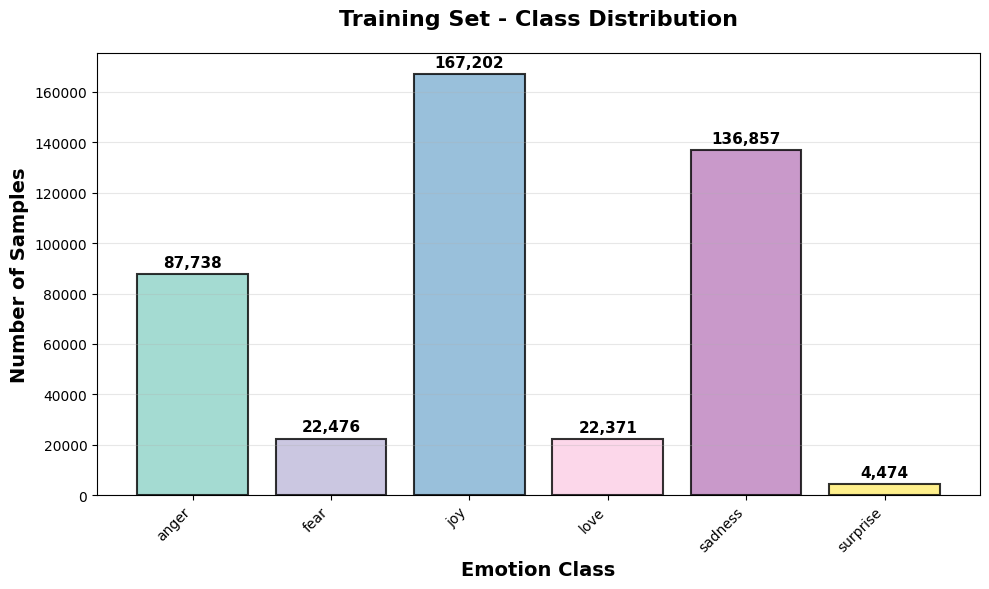


Training Set Statistics:
----------------------------------------
anger     : 87,738 samples ( 19.9%)
fear      : 22,476 samples (  5.1%)
joy       : 167,202 samples ( 37.9%)
love      : 22,371 samples (  5.1%)
sadness   : 136,857 samples ( 31.0%)
surprise  :  4,474 samples (  1.0%)
Total     : 441,118 samples
Data loading completed in 11.42s


In [15]:
trainer.load_data()

In [16]:
trainer.setup_tokenizer(
    max_tokens=CONFIG['max_tokens'],
    max_length=CONFIG['max_length'],
    adapt_size=100000,
    random_sample=True
)

Starting Tokenizer setup...

Setting up simple tokenizer
Vocabulary: 10,000  Max length: 384  Adapt size: 100000
Top 10 words: ['', '[UNK]', np.str_('i'), np.str_('the'), np.str_('you'), np.str_('to'), np.str_('a'), np.str_('and'), np.str_('is'), np.str_('it')]
Tokenizer setup completed in 20.65s


In [17]:
trainer.create_datasets(batch_size=CONFIG['batch_size'], tokenize_in_pipeline=True)
trainer.compute_class_weights()

Starting Tokenizer setup...

CREATING DATASETS

Dataset Configuration:
   Batch size:         16
   Tokenize in pipeline: True
   Prefetch:           AUTOTUNE
   Shuffle buffer:     100,000
Tokenizer setup completed in 1.59s

  COMPUTING CLASS WEIGHTS

Class Weights (for balanced training):
   anger     : 0.838
   fear      : 3.271
   joy       : 0.440
   love      : 3.286
   sadness   : 0.537
   surprise  : 16.433


In [18]:
trainer.build_model(
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    ff_dim=CONFIG['ff_dim'],
    num_blocks=CONFIG['num_blocks'],
    dropout_rate=CONFIG['dropout_rate']
)

Starting Model building...

 BUILDING TRANSFORMER MODEL

Model Architecture:
   Embedding dimension:  48
   Number of heads:      4
   Feed-forward dim:     192
   Transformer blocks:   1
   Dropout rate:         0.2
   Total parameters:     545,622
Model building completed in 1.54s


Starting Model training...

TRAINING TRANSFORMER MODEL
Training Configuration:
   Max epochs:         6
   Early stopping:     1 epochs patience
   Learning rate:      0.0002
   Batch size:         16
   Class weighting:    Enabled
Epoch 1/6
27570/27570 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4120 - loss: 1.4705
Epoch 1: val_accuracy improved from None to 0.58997, saving model to output\transformer_model.keras
27570/27570 ━━━━━━━━━━━━━━━━━━━━ 6549s 237ms/step - accuracy: 0.5145 - loss: 1.2150 - val_accuracy: 0.5900 - val_loss: 1.1372 - learning_rate: 2.0000e-04
Epoch 2/6
27570/27570 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.6204 - loss: 0.8586
Epoch 2: val_accuracy improved from 0.58997 to 0.63301, saving model to output\transformer_model.keras
27570/27570 ━━━━━━━━━━━━━━━━━━━━ 14601s 530ms/step - accuracy: 0.6221 - loss: 0.8532 - val_accuracy: 0.6330 - val_loss: 0.9743 - learning_rate: 2.0000e-04
Epoch 3/6
27570/27570 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.632

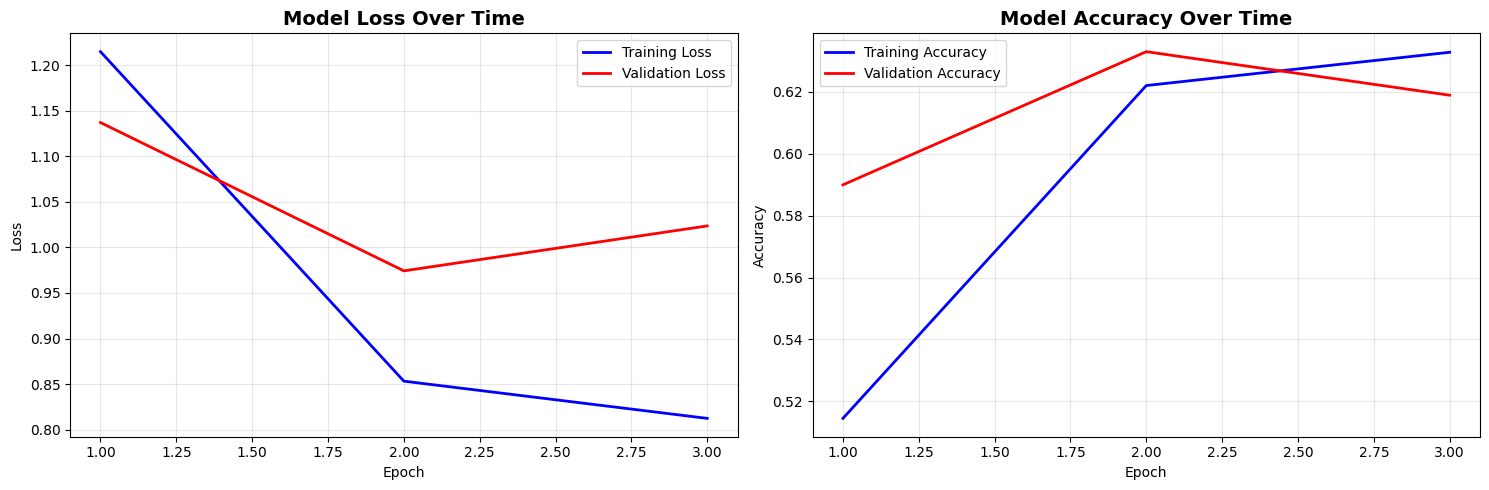

Model training completed in 28210.31s


In [19]:
trainer.train(
    epochs=CONFIG['epochs'], 
    patience=CONFIG['patience']
)

Starting Model evaluation...

COMPREHENSIVE MODEL EVALUATION

3447/3447 ━━━━━━━━━━━━━━━━━━━━ 246s 71ms/step
TRANSFORMER MODEL PERFORMANCE
Overall Test Accuracy: 0.6336 (63.36%)

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.67      0.65      0.66     10967
        fear       0.36      0.70      0.48      2810
         joy       0.79      0.56      0.66     20901
        love       0.37      0.76      0.50      2796
     sadness       0.71      0.68      0.70     17107
    surprise       0.20      0.81      0.33       559

    accuracy                           0.63     55140
   macro avg       0.52      0.69      0.55     55140
weighted avg       0.69      0.63      0.65     55140


Generating Evaluation Visualizations...

Confusion Matrix:


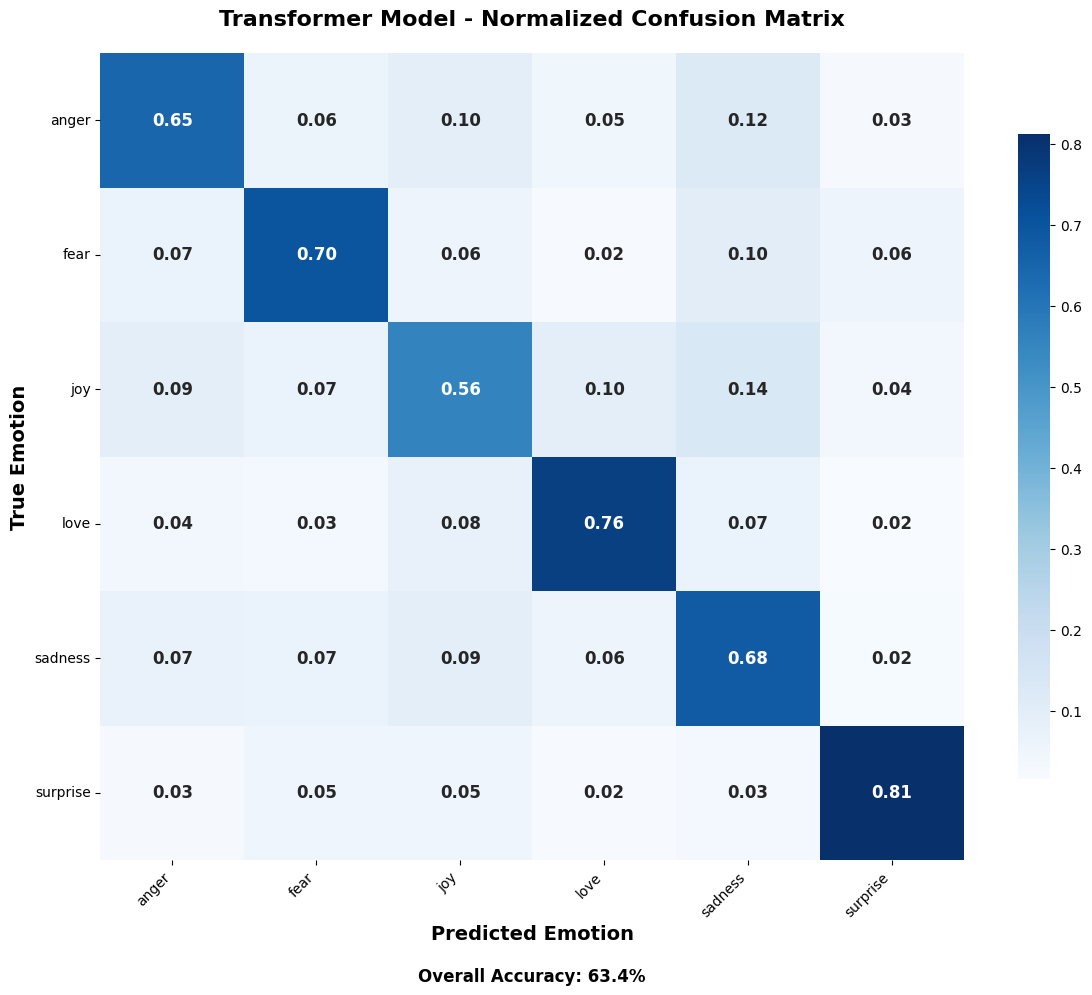


2Overall Performance Metrics:


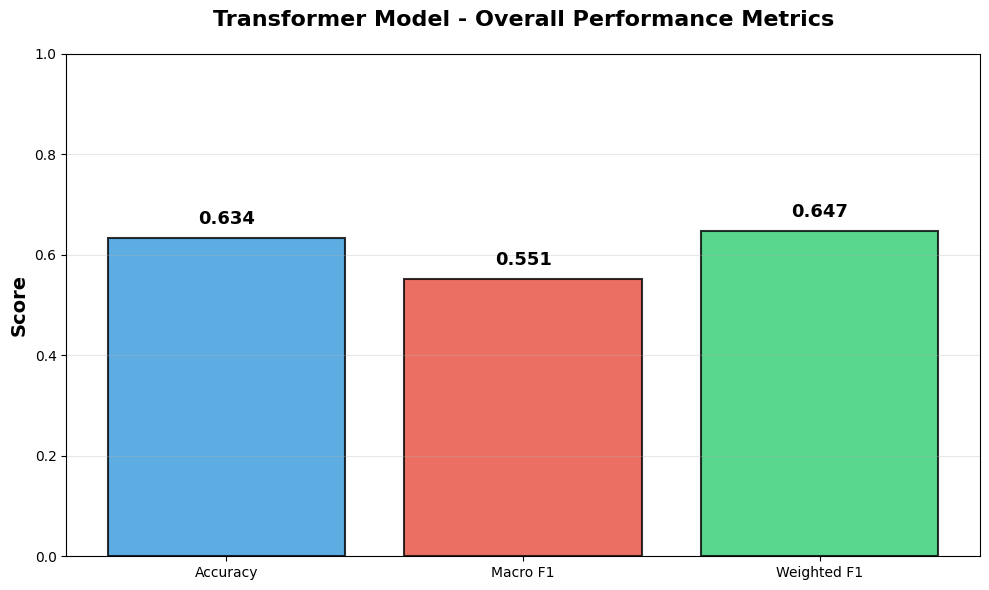


Per-Class F1 Scores:


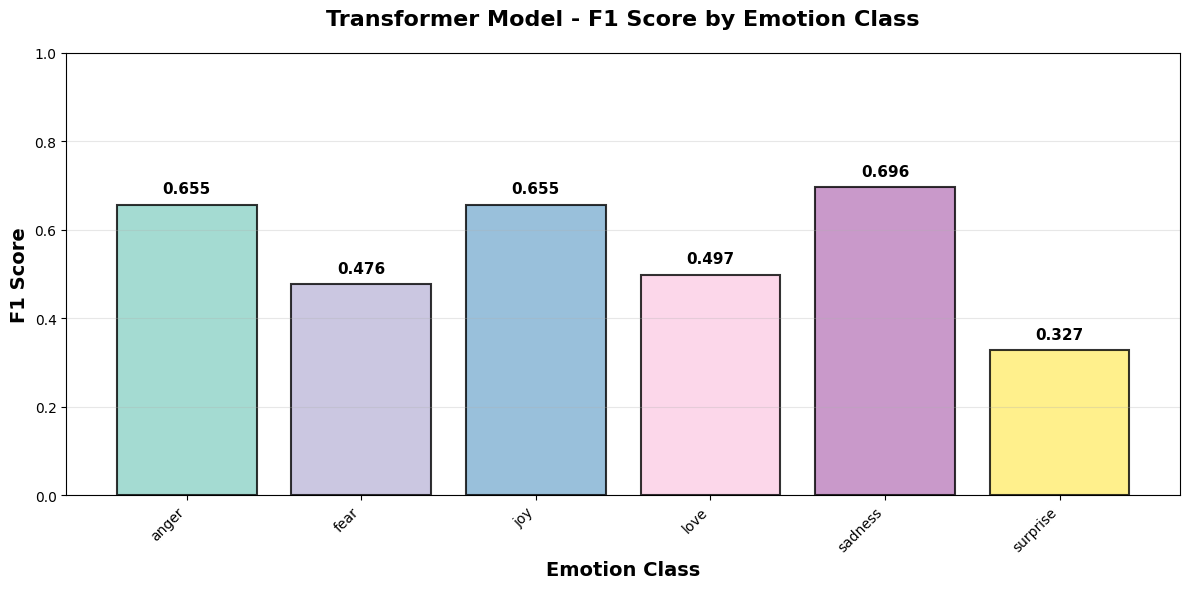


ROC Curves:


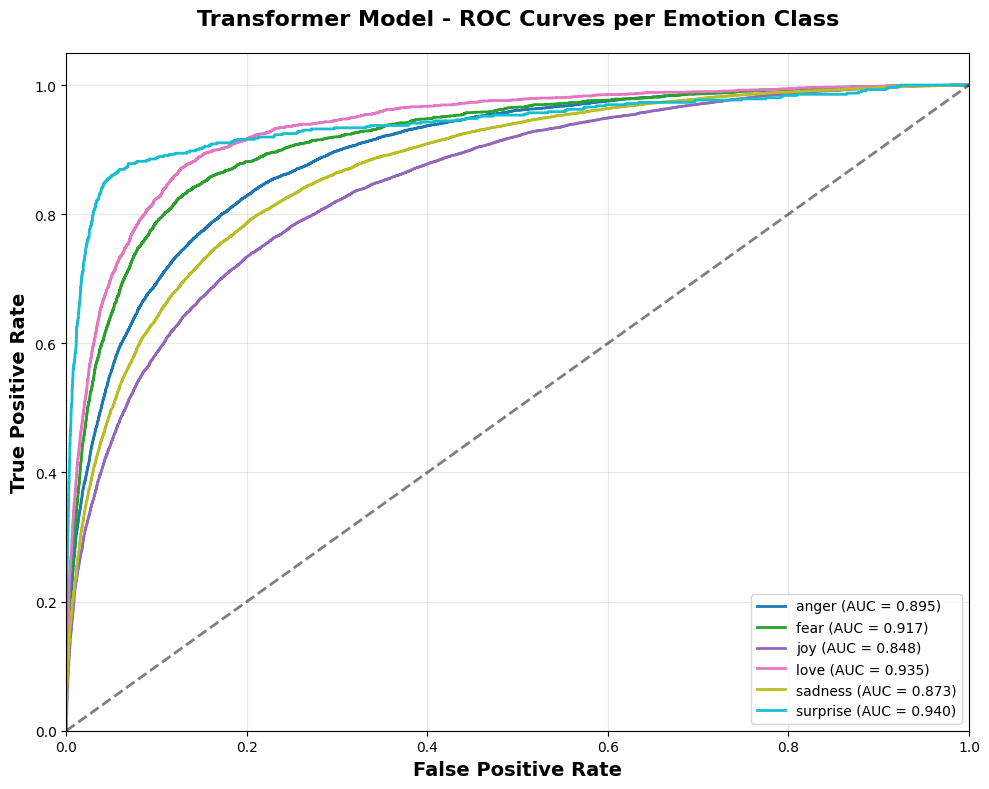


Precision-Recall Curves:


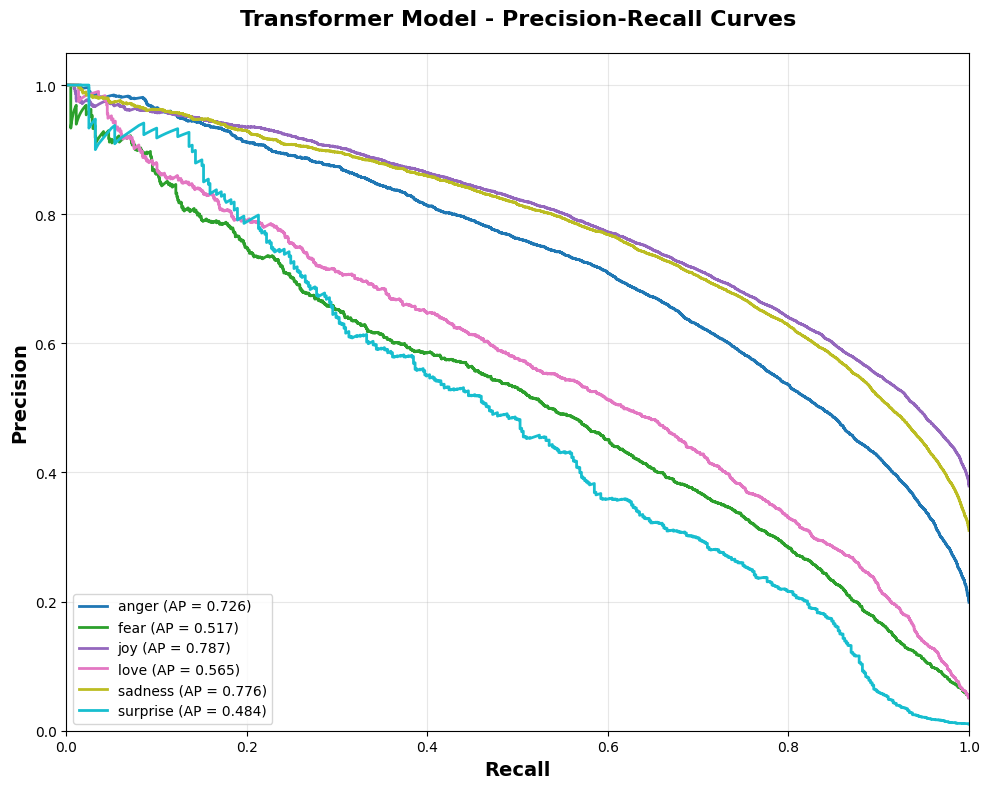

Model evaluation completed in 254.85s
Starting Saving artifacts...

SAVING MODEL ARTIFACTS
Saved artifacts:
   Model:        output\transformer_model.keras
   Tokenizer:    output\tokenizer.pkl
   Config:       output\config.json
Saving artifacts completed in 0.15s


In [20]:
results = trainer.evaluate()
trainer.save_artifacts()

In [21]:
def predict_single_sample(model, tokenizer, text, emotion_names, top_k=3):
    tokens = tokenizer([text])
    predictions = model.predict(tokens, verbose=0)[0]
    
    top_indices = np.argsort(predictions)[::-1][:top_k]
    
    print(f"\nLyrics Sample:")
    print("-" * 50)
    print(f"{text[:200]}{'...' if len(text) > 200 else ''}")

    print(f"\nTop {top_k} Emotion Predictions:")
    print("-" * 50)
    for i, idx in enumerate(top_indices, 1):
        emotion = emotion_names[idx]
        confidence = predictions[idx] * 100
        bar_length = int(confidence / 5)
        bar = "█" * bar_length + "░" * (20 - bar_length)
        print(f"{i}. {emotion:10} {confidence:5.1f}% |{bar}|")
    
    return emotion_names[top_indices[0]], predictions[top_indices[0]]

In [22]:
def demonstrate_predictions(results, trainer):
    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS DEMONSTRATION")
    print("="*60)

    sample_lyrics = [
        "dont forget me time flies sometimes it lasts in love but sometimes it hurts instead",
        "but maybe this thing was a masterpiece until you tore it all up so casually cruel in the name of being honest",
        "darling just kiss me slow your heart is all i own and in your eyes you are holding mine"
    ]
    expected_emotions = [
        "sadness",
        "anger",
        "love"
    ]

    model = results['best_model']

    for i, (text, expected) in enumerate(zip(sample_lyrics, expected_emotions), 1):
        print(f"\n{'='*60}")
        print(f"SAMPLE {i}/3")
        print('='*60)

        predicted_label, confidence = predict_single_sample(
            model, trainer.tokenizer, text, trainer.emotion_names, top_k=3
        )
        print(f"\nPredicted emotion: {predicted_label} ({confidence*100:.1f}%)")
        print(f"Expected emotion:  {expected}")


In [23]:
demonstrate_predictions(results, trainer)


SAMPLE PREDICTIONS DEMONSTRATION

SAMPLE 1/3

Lyrics Sample:
--------------------------------------------------
dont forget me time flies sometimes it lasts in love but sometimes it hurts instead

Top 3 Emotion Predictions:
--------------------------------------------------
1. sadness     75.1% |███████████████░░░░░|
2. love        18.7% |███░░░░░░░░░░░░░░░░░|
3. joy          2.9% |░░░░░░░░░░░░░░░░░░░░|

Predicted emotion: sadness (75.1%)
Expected emotion:  sadness

SAMPLE 2/3

Lyrics Sample:
--------------------------------------------------
but maybe this thing was a masterpiece until you tore it all up so casually cruel in the name of being honest

Top 3 Emotion Predictions:
--------------------------------------------------
1. anger       76.8% |███████████████░░░░░|
2. sadness     18.6% |███░░░░░░░░░░░░░░░░░|
3. joy          1.6% |░░░░░░░░░░░░░░░░░░░░|

Predicted emotion: anger (76.8%)
Expected emotion:  anger

SAMPLE 3/3

Lyrics Sample:
------------------------------------------

In [24]:
trainer.print_timing_summary()


 PERFORMANCE TIMING SUMMARY
Operation                 Time (s)   Percentage  
--------------------------------------------------
Data loading                11.42s        0.0%
Tokenizer setup              1.59s        0.0%
Model building               1.54s        0.0%
Model training            28210.31s       99.1%
Model evaluation           254.85s        0.9%
Saving artifacts             0.15s        0.0%
--------------------------------------------------
TOTAL                     28479.85s      100.0%


In [25]:
print("- PIPELINE COMPLETED SUCCESSFULLY! -")

        
print(f"\nSummary:")
print(f"    Model trained and saved to: {MODEL_PATH}")
print(f"    Tokenizer saved to: {TOKENIZER_PATH}")
print(f"    Configuration saved to: {CONFIG_PATH}")
        
final_acc = accuracy_score(results['y_true'], results['y_pred'])
print(f"    Final test accuracy: {final_acc:.1%}")

- PIPELINE COMPLETED SUCCESSFULLY! -

Summary:
    Model trained and saved to: output\transformer_model.keras
    Tokenizer saved to: output\tokenizer.pkl
    Configuration saved to: output\config.json
    Final test accuracy: 63.4%
